## Intro to Business Analytics Assignment 1

### Contributors
- Stanisław Howard
- Alexis Van den Heede
- Matthias Van Mechelen


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

this is a test

In [2]:
df = pd.read_csv('data/Trips_2018.csv')

In [3]:
df_copy = df.copy()
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [4]:
# rerun this to save time if you make a typo and need original df again
df = df_copy.copy()

In [5]:
# col 0 is unnamed make it trip_id and index
df.rename(columns={'Unnamed: 0':'trip_id'}, inplace=True)
df.set_index('trip_id', inplace=True)
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
trip_id,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [6]:
# start time and stop time to datetime
df['starttime'] = pd.to_datetime(df['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
df['stoptime'] = pd.to_datetime(df['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
trip_id,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [7]:
# make user type dummy
df = pd.get_dummies(df, columns=['usertype'], dtype=int)
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,usertype_Customer,usertype_Subscriber
trip_id,,,,,,,,,,,,,,
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1992,1,0,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1969,1,0,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1956,1,0,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1974,1,0,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1992,1,0,1


In [8]:
# plot
def plot_map(coords):
    plt.scatter(coords[:,0], coords[:,1], s=0.75)
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    plt.show()

In [9]:
# get lat and long
coords = df[['start_station_longitude','start_station_latitude']].values
coords = np.unique(coords, axis=0)


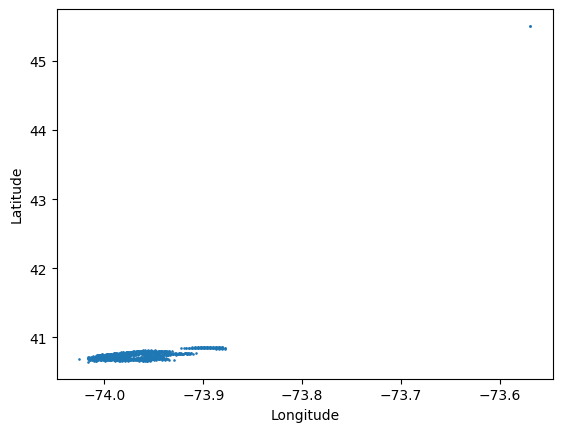

In [10]:
plot_map(coords)

Notice outlier

In [11]:
# get rid of outlier longitude > -73.6
coords = coords[coords[:,0] < -73.6]

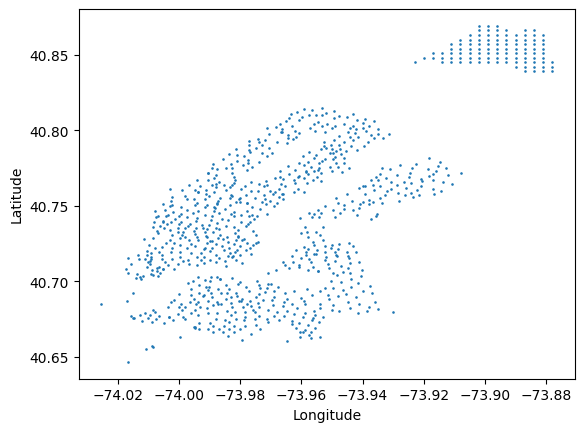

In [12]:
plot_map(coords)

Notice grid, check for nan, get rid of nan

In [13]:
# print where nan is in df
print(df.isnull().sum())
df = df[~np.isnan(df['start_station_id'])]
df = df[~np.isnan(df['end_station_id'])]
# get rid of row where longitude > -73.6
df = df[df['start_station_longitude'] < -73.6]
df = df[df['end_station_longitude'] < -73.6]
# get lat and long
coords = df[['start_station_longitude','start_station_latitude']].values
coords = np.unique(coords, axis=0)

tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
birth_year                    0
gender                        0
usertype_Customer             0
usertype_Subscriber           0
dtype: int64


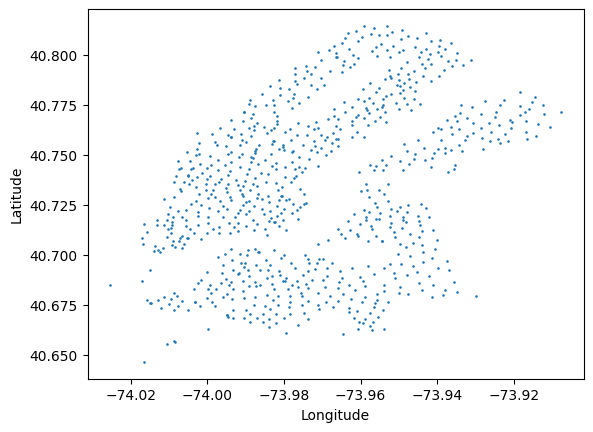

In [14]:
plot_map(coords)

In [15]:
# import kmeans
from sklearn.cluster import KMeans

In [16]:
# make kmeans model
kmeans = KMeans(n_clusters=20, random_state=0).fit(coords) # using coords here instead of df to increase speed

C:\Users\alexi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Train on coords to save time, then predict to save labels on df, trained on same data as predict so will be correct

In [21]:
df['label'] = kmeans.predict(df[['start_station_longitude','start_station_latitude']].values)

In [20]:
print(df.head())
df.describe()

         tripduration               starttime                stoptime   
trip_id                                                                 
0                 970 2018-01-01 13:50:57.434 2018-01-01 14:07:08.186  \
1                 723 2018-01-01 15:33:30.182 2018-01-01 15:45:33.341   
2                 496 2018-01-01 15:39:18.337 2018-01-01 15:47:35.172   
3                 306 2018-01-01 15:40:13.372 2018-01-01 15:45:20.191   
4                 306 2018-01-01 18:14:51.568 2018-01-01 18:19:57.642   

         start_station_id  start_station_latitude  start_station_longitude   
trip_id                                                                      
0                    72.0               40.767272               -73.993929  \
1                    72.0               40.767272               -73.993929   
2                    72.0               40.767272               -73.993929   
3                    72.0               40.767272               -73.993929   
4                   

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,usertype_Customer,usertype_Subscriber,label
count,1.754576e+07,17545760,17545760,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07,1.754576e+07
mean,9.883411e+02,2018-07-16 04:30:37.407817472,2018-07-16 04:47:06.250591232,1.589273e+03,4.073733e+01,-7.398261e+01,1.580821e+03,4.073700e+01,-7.398283e+01,2.656028e+04,1.978991e+03,1.148621e+00,1.101385e-01,8.898615e-01,9.876309e+00
min,6.100000e+01,2018-01-01 00:01:50.650000,2018-01-01 00:05:07.438000,7.200000e+01,4.064654e+01,-7.402535e+01,7.200000e+01,4.064654e+01,-7.408364e+01,1.452900e+04,1.885000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.580000e+02,2018-05-08 20:59:28.297999872,2018-05-08 21:16:46.886249984,3.800000e+02,4.071755e+01,-7.399521e+01,3.800000e+02,4.071755e+01,-7.399595e+01,2.029300e+04,1.969000e+03,1.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00
50%,6.050000e+02,2018-07-19 16:32:47.462500096,2018-07-19 16:50:36.848000,5.050000e+02,4.073818e+01,-7.398565e+01,5.050000e+02,4.073756e+01,-7.398602e+01,2.826900e+04,1.981000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+01
75%,1.060000e+03,2018-09-27 14:54:44.026249984,2018-09-27 15:09:34.373999872,3.249000e+03,4.075763e+01,-7.397283e+01,3.249000e+03,4.075725e+01,-7.397344e+01,3.185000e+04,1.989000e+03,1.000000e+00,0.000000e+00,1.000000e+00,1.500000e+01
max,1.951005e+07,2018-12-31 23:59:51.085000,2019-01-08 08:39:45.018000,3.721000e+03,4.081439e+01,-7.390774e+01,3.721000e+03,4.081439e+01,-7.390774e+01,3.583100e+04,2.002000e+03,2.000000e+00,1.000000e+00,1.000000e+00,1.900000e+01
std,1.889178e+04,NaN,NaN,1.439428e+03,3.055744e-02,1.907803e-02,1.438499e+03,3.033265e-02,1.914617e-02,6.222635e+03,1.192900e+01,5.438034e-01,3.130623e-01,3.130623e-01,5.577158e+00


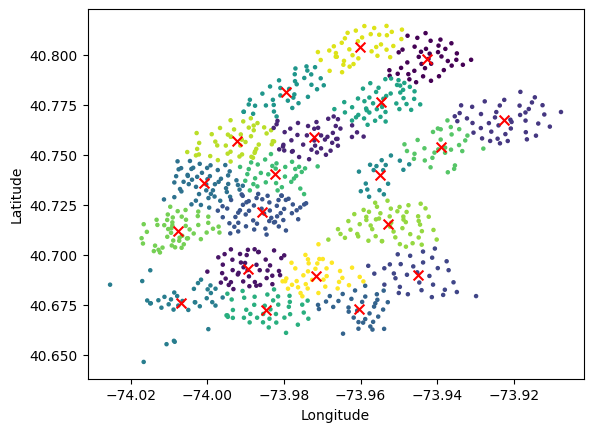

In [18]:
# plot with cluster colour & centriods
plt.scatter(coords[:,0], coords[:,1], c=kmeans.labels_, s=5)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='red', marker="x", s=50)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

Collaboration # not included in wordcouter.py
